In [1]:
import ee
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
ee.Initialize()

In [3]:
North_China_Plain_Boundary = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

### Fig_3_1_A heat map of Landsat data

In [8]:
# get the Landsat TOA data
Landsat_5 = ee.ImageCollection("LANDSAT/LT05/C01/T1_TOA").filterDate('1990-01-01','2010-12-31').filterBounds(North_China_Plain_Boundary)
Landsat_7 = ee.ImageCollection("LANDSAT/LE07/C01/T1_TOA").filterDate('2011-01-01','2013-12-31').filterBounds(North_China_Plain_Boundary)
Landsat_8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_TOA").filterDate('2014-01-01','2019-12-31').filterBounds(North_China_Plain_Boundary)

In [82]:
# Calculate how many Landsat images are included

# ID = []

# for year in range(1990,2020):   
        
#     year_start = f'{year}-01-01'
#     year_end   = f'{year}-12-31'

#     if   year <= 2010:            
#         year_Landsat = Landsat_5.filterDate(year_start,year_end)

#     elif year <= 2013:
#         year_Landsat = Landsat_7.filterDate(year_start,year_end)

#     elif year <= 2019:
#         year_Landsat = Landsat_8.filterDate(year_start,year_end)
    
    
#     # get the "id"
#     Info_fe_col = year_Landsat.map(lambda x : ee.Feature(ee.Geometry.Point(0,0),{'id':x.id()}))
#     Info_list   = Info_fe_col.getInfo()['features']
#     Info        = [d['id'] for d in Info_list]
    
#     # add the info into ID
#     ID.extend(Info)
    
#     # print out the process
#     print(f'Retrive info of year {year} complete!')

In [45]:
# # get the Sensor,Path,Date information
# Sensor = [s.split('_')[0] for s in ID]
# Path   = [s.split('_')[1] for s in ID]
# Date   = [s.split('_')[2] for s in ID]

# # create a df from Sensor, Path, Date
# ID_df = pd.DataFrame([Sensor,Path,Date]).T
# ID_df.columns = ['Sensor','Path','Date']

# # create Year and Month column
# ID_df['Year'] = ID_df['Date'].apply(lambda x:x[:4])
# ID_df['Month'] = ID_df['Date'].apply(lambda x:x[4:6])

# # save the df to csv
# ID_df.to_csv('./Calculationg_result/Fig_3_Landsat_distribution.csv',index =False)

# load the df 
ID_df = pd.read_csv('./Calculationg_result/Fig_3_Landsat_distribution.csv')

In [107]:
tmp = ID_df[['Year','Month']]
tmp['One'] = 1
tt = tmp.groupby(['Year','Month']).sum().unstack(0)
tt.columns = range(1990,2020)

tt.sort_index(ascending=False,inplace=True)

C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


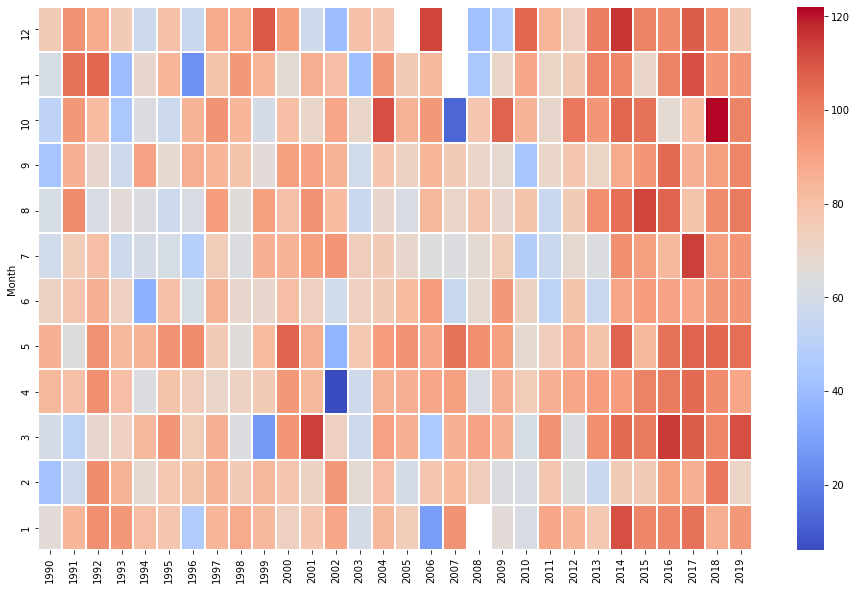

In [108]:
plt.figure(figsize=(16,10))
sns.heatmap(tt,linecolor='white',linewidths=1,cmap='coolwarm')

### Fig_3_2_The landsat overlay map

In [118]:
# get the mask img, which indicate the footprint the landsat img, where 1 
# mean valid pixel and 0 indicate invalid pixel

Landsat_5_sum = Landsat_5.map(lambda img: img.mask().reduce('min')).sum()
Landsat_7_sum = Landsat_7.map(lambda img: img.mask().reduce('min')).sum()
Landsat_8_sum = Landsat_8.map(lambda img: img.mask().reduce('min')).sum()


# define a geometry for export
landsat_8_raw = ee.ImageCollection("LANDSAT/LC08/C01/T1")\
                  .filterDate('2019-01-01','2019-12-31')\
                  .filterBounds(North_China_Plain_Boundary)

export_region = landsat_8_raw.geometry().bounds()

In [119]:
for img,name in zip([Landsat_5_sum,Landsat_7_sum,Landsat_8_sum],
                  ['Landsat_5_sum','Landsat_7_sum','Landsat_8_sum']):
    
    # export to Google Storage
    task = ee.batch.Export.image.toCloudStorage(image          = img.toUint16(),
                                                description    = name,
                                                bucket         = 'north_china_plain',
                                                fileNamePrefix = name,
                                                region         = export_region,
                                                scale          = 30,
                                                maxPixels      = int(1e13),
                                                skipEmptyTiles = True)
    task.start()
    
    print(f'Exporting {name} successful!')
    

Exporting Landsat_5_sum successful!
Exporting Landsat_7_sum successful!
Exporting Landsat_8_sum successful!
